# Original SegFormer Model for Burned Area Segmentation

This implementation is using the original segformer model from huggingface with a customized dataset class and validation function. Using MiT-b3 backbone

## 📌 Notebook Structure:

1. **Requirements and Imports**: Setting up the environment.
2. **Model Definition**: Customized U-Net architecture details.
3. **Dataset Definition**: Preprocessing and loading the data.
4. **Training Function**: Implementation of the training loop.
5. **Validation Function**: Checking model performance on unseen data.
6. **Read Data from Google Drive**: Integration with Google Drive for dataset access.
7. **Training Configs and Hyperparameters**: Setting up parameters for optimal training.
8. **Training**: Initiating the model training process.
9. **Validation and Testing**: Evaluating model performance.
10. **Visualize Results**: Displaying segmentation results visually.

In [1]:
### INSTALL REQUIREMENTS
!pip install -q numpy
!pip install -q torch
!pip install -q PILlow
!pip install -q tqdm
!pip install -q transformers
!pip install -q thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from thop import profile
from multiprocessing import cpu_count

In [ ]:
### MODEL

image_processor = SegformerImageProcessor(do_reduce_labels=False)

# create custom json id and label file, where 1 is the object and 0 is the background
id2label = {
    0: "background",
    1: "object",
}

label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id,
)


In [4]:
### DATASET

class BurnedAreaDataset(Dataset):

    def __init__(self, images_src, masks_src, processor):

        imgs = list(Path(images_src).glob("**/*0.jpeg"))
        masks = list(Path(masks_src).glob("**/*0.jpeg"))

        imgs = {img.stem: img for img in imgs}
        self.data = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_src, mask_src = self.data[idx]

        image = Image.open(str(image_src))
        segmentation_map = Image.open(str(mask_src)).convert("L")
        segmentation_map_np = np.array(segmentation_map)
        segmentation_map_np_mask = np.where(segmentation_map_np > 127, 1, 0).astype(np.uint8)
        segmentation_map = Image.fromarray(segmentation_map_np_mask)

        encoded_inputs = self.processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    def output_sample(self, idx):

        image_src, mask_src = self.data[idx]

        image = Image.open(str(image_src))
        segmentation_map = Image.open(str(mask_src)).convert("L")
        segmentation_map_np = np.array(segmentation_map)
        segmentation_map_np_mask = np.where(segmentation_map_np > 127, 1, 0).astype(np.uint8)
        segmentation_map = Image.fromarray(segmentation_map_np_mask)

        # encoded_inputs = self.processor(image, segmentation_map, return_tensors="pt")

        # for k,v in encoded_inputs.items():
        #     encoded_inputs[k].squeeze_() # remove batch dimension

        return image, segmentation_map

In [5]:
### TRAINING LOOP

def train(
    model,
    num_epochs,
    patience,
    train_dataloader,
    val_dataloader,
    save_path,
    optimizer,
    scheduler,
    device,
):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        print("Epoch:", epoch)
        best_loss = 999.0
        num_stop = 0
        train_loss = 0

        for idx, batch in enumerate(tqdm(train_dataloader)):

            # get the inputs;
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dataloader)

        val_loss, accuracy = validate_model(model, val_dataloader, device)
        f1_score = accuracy['avg_f1']

        if val_loss < best_loss:
            best_loss = val_loss
            num_stop = 0
            torch.save(model.state_dict(), save_path + "/best_model.pth")
        else:
            num_stop += 1

        if num_stop == patience:
            print("Early stopping")
            break
        if scheduler is not None:

            scheduler.step()
        curr_lr = optimizer.param_groups[0]['lr']

        print(f'EPOCH: {epoch}, LR: {curr_lr}')
        print(f'Train loss: {avg_train_loss}, Val loss: {val_loss}, Val F1: {f1_score}')

    torch.save(model.state_dict(), save_path + "/best_model.pth")



In [6]:
### VALIDATING LOOP

def get_f1(label, predict):
    # dice acc
    predict = (predict > 0.5).float()

    intersection = (predict * label).sum()

    f1_acc = (2 * intersection) / (label.sum() + predict.sum() + 1e-8)

    return f1_acc

def get_iou(label, predict):
    predict = (predict > 0.5).float()

    intersection = (predict * label).sum()
    union = label.sum() + predict.sum() - intersection

    return (intersection + 1e-8) / (union + 1e-8)

def get_mcc(label, predict):
    predict = (predict > 0.5).float()

    tp = (predict * label).sum()
    fp = (predict * (1 - label)).sum()
    fn = ((1 - predict) * label).sum()
    tn = ((1 - predict) * (1 - label)).sum()

    numerator = tp * tn - fp * fn
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    return numerator / (denominator + 1e-8)

def validate_model(
    model,
    dataloader,
    device
):
    model.eval()

    running_f1 = 0.0
    running_iou = 0.0
    running_mcc = 0.0
    running_loss = 0.0

    n = 0

    for batch in tqdm(dataloader):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        if labels[0].cpu().sum() == 0:
            continue

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss.cpu(), outputs.logits.cpu()

        running_loss += loss.item()

        upsampled_logits = nn.functional.interpolate(logits,
                    size=labels.shape[-2:], # (height, width)
                    mode='bilinear',
                    align_corners=False)

        seg = upsampled_logits.argmax(dim=1).float()

        running_f1 +=  get_f1(labels.cpu(), seg)
        running_iou += get_iou(labels.cpu(), seg)
        running_mcc += get_mcc(labels.cpu(), seg)

        n += 1

    avg_running_loss = running_loss / n
    accuracy = {}
    accuracy['avg_f1'] = running_f1 / n
    accuracy['avg_iou'] = running_iou / n
    accuracy['avg_mcc'] = running_mcc / n

    return avg_running_loss, accuracy

In [18]:
### READ DATA

IMG_SIZE = 512
BATCH_SIZE = 8
NUM_WORKERS = cpu_count()
ROOT = "/content/drive/MyDrive/ResearchProject/datasets/universal_512_final_final/train_dataset"
MODEL_SAVE_PATH = "/content/drive/MyDrive/ResearchProject/models/SegFormer_b3"

TRAIN_IMG_DIR = ROOT + "/images/train_images"
TRAIN_MASK_DIR = ROOT + "/masks/train_masks"
VAL_IMG_DIR = ROOT + "/images/val_images"
VAL_MASK_DIR = ROOT + "/masks/val_masks"
TEST_IMG_DIR = ROOT + '/images/test_images'
TEST_MASK_DIR = ROOT + '/masks/test_masks'

train_dataset = BurnedAreaDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, processor=image_processor)
valid_dataset = BurnedAreaDataset(VAL_IMG_DIR, VAL_MASK_DIR, processor=image_processor)
test_dataset = BurnedAreaDataset(TEST_IMG_DIR, TEST_MASK_DIR, processor=image_processor)



train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True
)

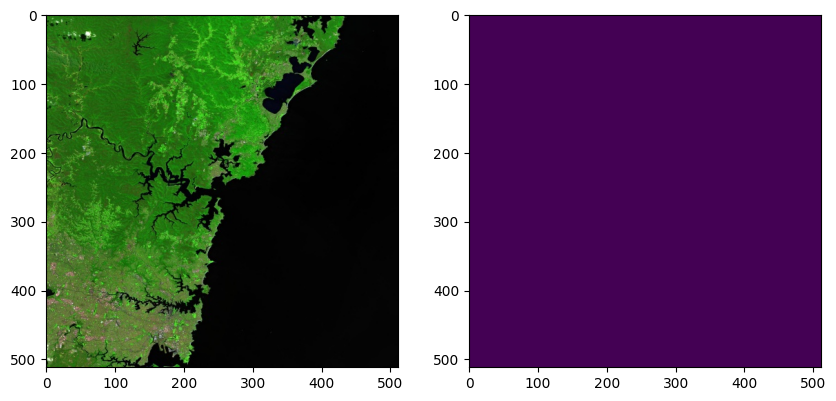

In [8]:
# sanity check
random_int = random.randint(0, len(train_dataset))
img, mask = train_dataset.output_sample(random_int)

img_np = np.array(img)
mask_np = np.array(mask)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.subplot(1, 2, 2)
plt.imshow(mask_np)
plt.show()

In [9]:
load = True
if load:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH + '/best_model.pth'))

In [10]:
### START TRAINING

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using CUDA")
else:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("using MPS")
    else:
        device = torch.device("cpu")
        print("using CPU")

NUM_EPOCHS = 500
PATIENCE = 100
LEARNING_RATE_0 = 0.0001
LEARNING_RATE_F = LEARNING_RATE_0 * 0.1
WEIGHT_DECAY = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE_0, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1,
    end_factor=0.1,
    total_iters=NUM_EPOCHS
)

using CUDA


In [ ]:
train(model=model,
      num_epochs=NUM_EPOCHS,
      patience=PATIENCE,
      train_dataloader=train_dataloader,
      val_dataloader=valid_dataloader,
      save_path=MODEL_SAVE_PATH,
      optimizer=optimizer,
      scheduler=scheduler,
      device=device)

In [19]:
### VALIDATION
loss, accuracy = validate_model(model, valid_dataloader, device)

  0%|          | 0/9 [00:00<?, ?it/s]

In [20]:
for k, v in accuracy.items():
    print(k, v)

avg_f1 tensor(0.8390)
avg_iou tensor(0.7427)
avg_mcc tensor(0.8316)


In [21]:
### TESTING
loss, accuracy = validate_model(model, test_dataloader, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
for k, v in accuracy.items():
    print(k, v)

avg_f1 tensor(0.8593)
avg_iou tensor(0.7638)
avg_mcc tensor(0.8533)


6
6


  0%|          | 0/6 [00:00<?, ?it/s]

0


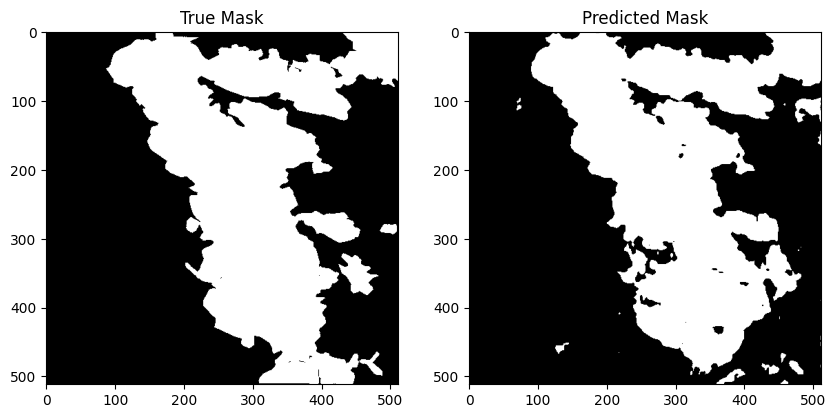

F1 Score: 0.9154
1


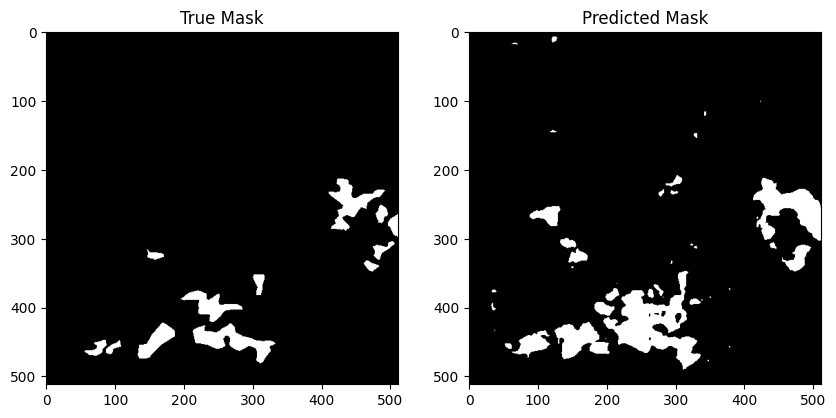

F1 Score: 0.6181
2


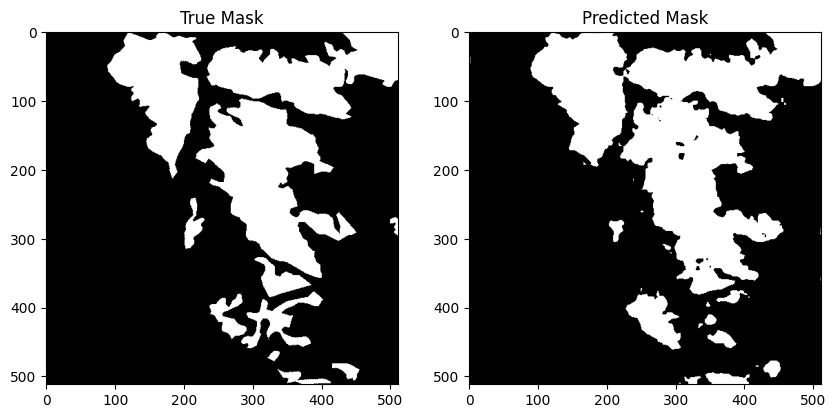

F1 Score: 0.8931
3


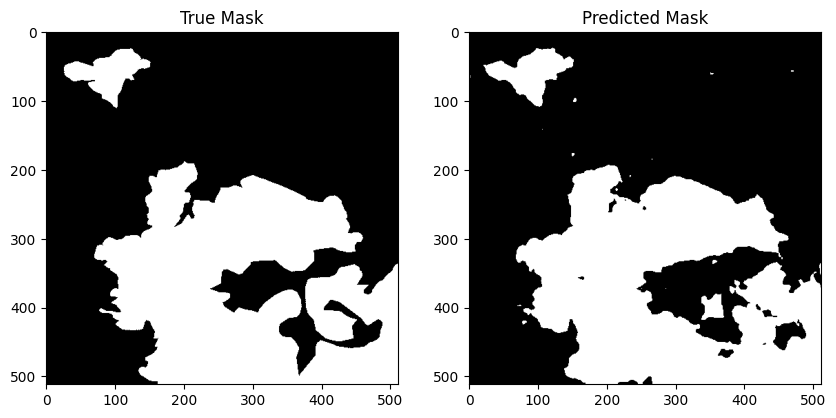

F1 Score: 0.9464
4


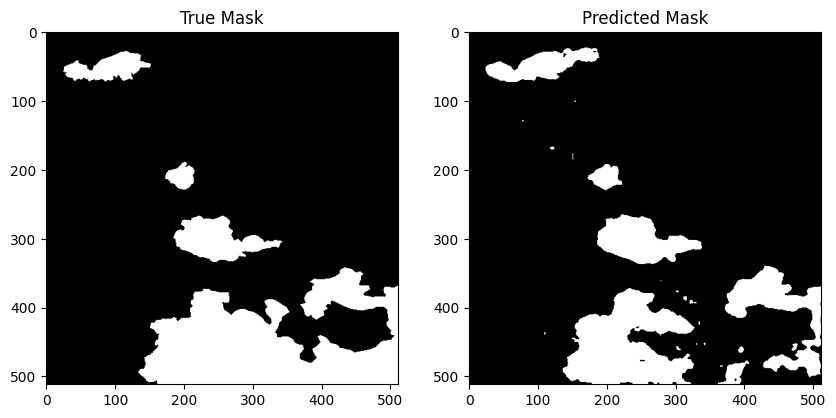

F1 Score: 0.8122
5


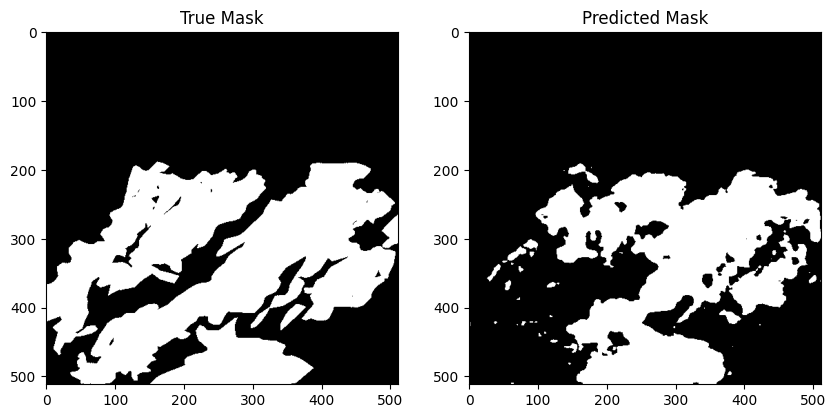

F1 Score: 0.7399


In [23]:
### VISUALIZING

VISUAL_IMG_DIR = ROOT + '/images/visual_check_images'
VISUAL_MASK_DIR = ROOT + '/masks/visual_check_masks'

imgs = list(Path(VISUAL_IMG_DIR).glob("**/*0.jpeg"))
masks = list(Path(VISUAL_MASK_DIR).glob("**/*0.jpeg"))

imgs = {img.stem: img for img in imgs}
data000 = [[imgs[mask.stem], mask] for mask in masks if imgs.get(mask.stem)]

print(len(data000))

visual_dataset = BurnedAreaDataset(VISUAL_IMG_DIR, VISUAL_MASK_DIR, processor=image_processor)
visual_dataloader = DataLoader(visual_dataset, batch_size=1)

print(len(visual_dataset))


model.eval()

for idx, batch in enumerate(tqdm(visual_dataloader)):
    print(idx)
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)

    if labels[0].cpu().sum() == 0:
        continue

    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(logits,
                size=labels.shape[-2:], # (height, width)
                mode='bilinear',
                align_corners=False)

    seg = upsampled_logits.argmax(dim=1).float()

    # Plot the predicted mask (grayscale) and true labels side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(labels[0].cpu(), cmap='gray')  # True mask
    plt.title('True Mask')

    plt.subplot(1, 2, 2)
    plt.imshow(seg[0].cpu(), cmap='gray')  # Predicted mask
    plt.title('Predicted Mask')

    plt.show()

    f1_score = get_f1(labels.cpu(), seg)
    print(f"F1 Score: {f1_score:.4f}")

In [24]:
input_tensor = torch.randn(1, 3, 512, 512).to('cuda')
flops, params = profile(model, inputs=(input_tensor,))
print(f"Flops: {flops:,}, Params: {params:,}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
Flops: 71,360,643,072.0, Params: 47,224,002.0
